# LBA
### CS 146, Fall 2019
#### Berfin Karaman

In [109]:
#import libraries
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from scipy import stats
sns.set()

In [224]:
#Import Data
data = pd.read_csv('LBA data.csv')
data.head()

,Timestamp,Email Address,Your name,Neigborhood,Grocery store,Grocery store street address,Apples Product 1 quantity (kg),Apples Product 1 price (€),Apples Product 2 quantity (kg),Apples Product 2 price (€),...,Eggs Product 2 quantity (count),Eggs Product 2 price (€),Eggs Product 3 quantity (count),Eggs Product 3 price (€),Chicken breasts Product 1 quantity (kg),Chicken breasts Product 1 price (€),Chicken breasts Product 2 quantity (kg),Chicken breasts Product 2 price (€),Chicken breasts Product 3 quantity (kg),Chicken breasts Product 3 price (€)
0,10/28/2019 13:14:59,brian.swanberg@minerva.kgi.edu,Brian Swanberg,Lichtenberg,ALDI,Rummelsburger Str. 98,0.88,2.20,1.00,1.88,...,6.0,1.59,10.0,1.59,0.60,3.99,1.000,5.99,NaN,NaN
1,10/29/2019 14:19:19,emma.stiefel@minerva.kgi.edu,Emma Stiefel,Neukölln,REWE,Karl-Marx-Straße 92-98,1.00,2.49,1.00,1.49,...,1.0,0.25,6.0,1.59,1.00,13.90,1.000,9.99,1.000,9.98
2,10/29/2019 21:22:30,taha@minerva.kgi.edu,Taha,Neukölln,ALDI,"Hermannstraße 72, 12049 Berlin, Germany",1.00,2.99,1.00,1.79,...,10.0,1.19,6.0,1.59,0.60,3.99,1.000,5.99,0.350,3.99
3,10/30/2019 16:20:11,michaelchen@minerva.kgi.edu,Michael Hao Chen,Mitte,Lidl,"Lidl, Leipziger Str. 42",1.00,1.79,0.75,1.99,...,10.0,1.69,10.0,2.65,0.60,3.99,0.400,2.79,NaN,NaN
4,10/30/2019 16:24:57,michaelchen@minerva.kgi.edu,Michael Hao Chen,Friedrichshain,REWE,"REWE, Landsberger Allee 68D",0.65,2.49,1.00,2.19,...,6.0,2.29,12.0,1.99,0.41,5.34,0.249,2.49,0.285,8.52


In [79]:
#Examination of non-numerical columns
#print(data['Grocery store'].value_counts(),'\n')
#print(data['Neigborhood'].value_counts(),'\n')

#I will map the categorical values of the ordinal data set into integers to
#turn them into multinominal variables
store = {"Grocery store": {"EDEKA": 1,
                            "Lidl": 2,
                            "ALDI": 3,
                            "REWE": 4,
                            "Tesco Express": 5,
                            "Safeway": 6,
                            "Waitrose & Partners": 7,
                            "SAINSBURY'S": 8,
                            "Tesco": 5,
                            "Sainsbury's": 8,
                            "Lotte Mart": 9,
                            "Sainsbury": 8,
                            "Waitrose": 7,
                            "Waitrose & Partners ": 7}}
data = data.replace(store)

neigborhood = {"Neigborhood": {"Kreuzberg": 1,
                            "Neukölln": 2,
                            "Mitte": 3,
                            "Friedrichshain": 4,
                            "Lichtenberg": 5,
                            "Schöneberg": 6,
                            "Alt-Treptow": 7,
                            "Prenzlauer Berg": 8,
                            "Tempelhof": 9,
                            "Seoul": 10,
                            "San Francisco": 11,
                            "London": 12}}
data = data.replace(neigborhood)

#Getting rid off the columns that are not usefull for the model
data = data.drop(["Timestamp", "Email Address", "Your name", "Grocery store street address"], axis=1)

In [80]:
# Delete all rows without Berlin
# By doing so we will loose 21 observation but it will make our results more realistic
# because firstly, we have more information about different neigborhoods in Berlin since
# the negihborhoods of other cities are not reported. Secondly, the currency is reported as euros
# but I do not trust the data collection methods because I highly doubt that people would put down the
# converted currency versions to the data entery. Thus I will focus on the Berlin data for this assignment.

nonberlin = data[ (data['Neigborhood'] >= 10)].index
data.drop(nonberlin, inplace=True)


In [82]:
#Since the prize of the products are not unit prizes, I would like to find the unit
#prices for each product by dividing the quantity of the good with the price

#for loop for the products with kg as their quantity unit
kglistofproducts = ["Apples", "Bananas", "Tomatoes", "Potatoes", "Flour, white", "Rice, basmati", "Butter", "Chicken breasts"]
for x in kglistofproducts:
    data[x+ ' price 1']=data[x+ ' Product 1 price (€)']/data[x+ ' Product 1 quantity (kg)']
    data[x+ ' price 2']=data[x+ ' Product 2 price (€)']/data[x+ ' Product 2 quantity (kg)']
    data[x+ ' price 3']=data[x+ ' Product 3 price (€)']/data[x+ ' Product 3 quantity (kg)']

data['Milk price 1']=data['Milk, full cream Product 1 price (€)']/data['Milk, full cream Product 1 quantity (liters)']
data['Milk price 2']=data['Milk, full cream Product 2 price (€)']/data['Milk, full cream Product 2 quantity (liters)']
data['Milk price 3']=data['Milk, full cream Product 3 price (€)']/data['Milk, full cream Product 3 quantity (liters)']

data['Eggs price 1']=data['Eggs Product 1 price (€)']/data['Eggs Product 1 quantity (count)']
data['Eggs price 2']=data['Eggs Product 2 price (€)']/data['Eggs Product 2 quantity (count)']
data['Eggs price 3']=data['Eggs Product 3 price (€)']/data['Eggs Product 3 quantity (count)']


#I will map the categorical values of the products into integers so I can write a for-loop to create subdata sets
#to drop the NaN values 
product_code  = {1: "Apples",
                2: "Bananas",
                3:"Tomatoes",
                4:"Potatoes",
                5:"Flour, white",
                6:"Rice, basmati",
                7:"Butter",
                8:"Chicken breasts",
                9:"Eggs",
                10:"Milk"}

#defining the empty lists for the multipliers to get data Stan ready
prices = []
stores = []
neigborhoods = []
product = []

for i in range(1, 11):
    x = product_code[i]
    #creating subdatasets to make it easier to eliminate nan values and the chose the required values
    price1 = data[[x+ ' price 1','Grocery store','Neigborhood']].dropna() 
    price2 = data[[x+ ' price 2','Grocery store','Neigborhood']].dropna() 
    price3 = data[[x+ ' price 3','Grocery store','Neigborhood']].dropna()
    
    xprices = price1[x+' price 1'].values.tolist() + price2[x+' price 2'].values.tolist() + price3[x+' price 3'].values.tolist()
    xstores = price1['Grocery store'].values.tolist() + price2['Grocery store'].values.tolist() + price3['Grocery store'].values.tolist()
    xneigborhood = price1['Neigborhood'].values.tolist() + price2['Neigborhood'].values.tolist() + price3['Neigborhood'].values.tolist()
    xproduct = len(xprices)*[i]
    #filling the lists with the mathcing data points for Stan
    prices += xprices
    stores += xstores
    neigborhoods += xneigborhood
    product += xproduct

#checking if they have the same length before Stan    
len(prices), len(stores), len(neigborhoods), len(product)

(1579, 1579, 1579, 1579)

In [89]:
#getting the data ready for stan

data = {
                'prices': prices,
                'stores': stores,
                'neigborhoods': neigborhoods,
                'product': product,
                'N': len(prices), 
                'alpha': 1.5,  
                'beta': 7
            }

In [212]:
stan_code = """
// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
// In this scenerio, observed data are given bellow and there is no constant
// hyperparameter because I will use a cauchy distribution
data {  
    int<lower=1> N; // length of the data
    real<lower=0> prices[N];  //data points for the prices
    int<lower=1, upper=4> stores[N]; // data points for the store types
    int<lower=1, upper=9> neigborhoods[N]; // data points for the neigborhood types
    int<lower=1, upper=10> product[N]; // data points for the product types
}
// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
// We will have the base price as a paramter than 2 multipliers for store and neigborhood
// LAstly we will define signma for normal distribution
parameters {  
    real<lower=1> base[11];
    real<lower=0> mul_stores[4];
    real<lower=0> mul_neigborhoods[9]; 
    real<lower = 0> sigma;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
// We will use normal distribution with the multipliers as the prior 
model {
    sigma ~ cauchy(0,1);
    
    for (i in 1:11){ 
       base[i] ~ cauchy(1, 1.5);
    }  
    for (i in 1:4){
        mul_stores[i] ~ cauchy(1,0.5);
    }
    for (i in 1:9){
        mul_neigborhoods[i] ~ cauchy(1,0.5);
    }

    for (i in 1:N){
        prices[i] ~ normal(base[product[i]] * mul_neigborhoods[neigborhoods[i]] * mul_stores[stores[i]], sigma);
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_986cbf8f5aef36cd96a0e82596de6f2b NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/g7/bvwq448s61g5r8534tlj1psc0000gn/T/tmpgyezrivk/stanfit4anon_model_986cbf8f5aef36cd96a0e82596de6f2b_7483349780286143823.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [213]:
fit = stan_model.sampling(data=data, chains=8, iter=20000, seed = 69)

#### Questions to Answer

##### What is the basic average price for each product? 

(You need to think carefully about how to anchor the basic price for each product since this will depend on the currency used as well as the distribution of prices.)

The basic average prices can be founded in the first column of the stan summary because the first column gives the mean value for each base.  Numbers of the base are equivalent to different product types such as apples, bananas, and so on. The mapping of the type of products into integers is defined as product_code, so to decode the numbers, product_code can be referred. I assumed that prices of the product are normally distributed on the multipliers of type of product, neighborhoods, and the brand of the supermarket chain. I created the priors for these multipliers by using Cauchy distirbution. The main reason why I chose Cauchy distribution is the heavy tails of the distirbution, which are useful for the situations where we are setting priors for a wide range of unknown variables. Heavy tails mean that when we are sampling, it is more likely that we can choose value away from the mean compared to other distribution with thinner tails. Additionally, as it is stated in the assignment description," we really don’t know the scale, use a broad prior over the base price of each product," it makes sense to chose Cauchy since it gives us a broad prior. 

It makes sense to center our half-Cauchy for the base price around 1 because I am using the Berlin data, and I know that the prices of the basic products tend to be closer to 1. However, I will set a relatively bigger scaler since we have products such as chicken breast and egg, which has a huge price discrepancy. After I run the model, I checked the base mean values of each product. It makes sense that the most expensive product is chicken breast. While the prices of eggs centered at a price lower than 1 Euro since we were assessing eggs per egg rather than a box.



Results:

Inference for Stan model: anon_model_986cbf8f5aef36cd96a0e82596de6f2b.
8 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=80000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
base[0]    3.18  4.5e-3   0.58   2.27   3.11   4.54  16529    1.0
base[1]    2.26  3.3e-3   0.46   1.53   2.21   3.31  18929    1.0
base[2]    6.06  8.6e-3   1.04   4.46   5.92   8.47  14678    1.0
base[3]    1.76  2.7e-3   0.38   1.16   1.72   2.62  19788    1.0
base[4]    1.69  2.6e-3   0.37   1.11   1.65   2.54  20481    1.0
base[5]    5.41  7.7e-3   0.94   3.97   5.28   7.62  15046    1.0
base[6]   10.47    0.01   1.75   7.79  10.22  14.59  14297    1.0
base[7]   13.28    0.02   2.22   9.89  12.97   18.5  14303    1.0
base[8]    1.09  4.0e-4   0.09    1.0   1.06   1.32  47781    1.0
base[9]    1.68  2.4e-3   0.36   1.11   1.64    2.5  21481    1.0
base[10]  26.54   14.47 2346.1   1.06    2.5  39.49  26304    1.0

Sam

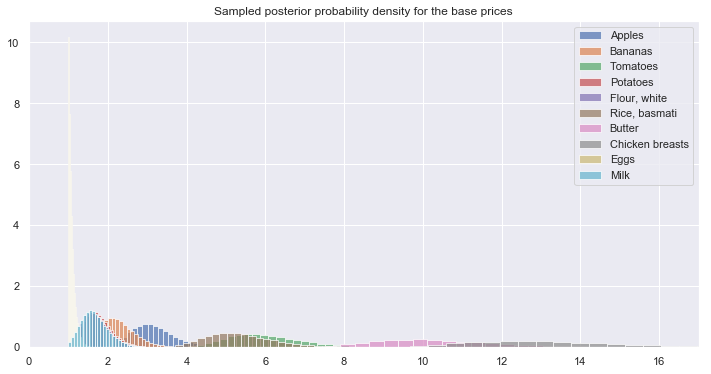

In [215]:
#Analysis of the base price for different products

stan_summary_baseprice = fit.stansummary(pars=['base'], probs=[0.025, 0.5, 0.975])
print('\nResults:\n')
print(stan_summary_baseprice)


#Plotting the posterior base to see the distribution
posterior = fit.extract()
plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for the base prices')
for i in range(10):
    plt.hist(posterior['base'][:,i],bins=50, density = True, alpha = 0.7, label = product_code[i+1]) 
plt.xlim((0,17))
plt.legend()
plt.show()

##### How much does each of the following factors modify the basic price of the product (up or down)?
*  Brand of the grocery store.
*  The geographical location of the grocery store. 


Based on the Stan model that I created in the previous cell, I can answer these questions by sampling from multiplier for stores and the multipliers for the neighborhoods. The individual multiplier of each store can be found in the first column of each stan summary. After I ran the code in the cell bellow, I realized that the most expensive store is Edeka. However, due to their standard error, Edeka partially overlaps with Rewe, when I plot the samples from the Stan Model in a histogram. It is expected that different brands of supermarkets will overlap due to market competition. They cannot set higher prices; otherwise, the consumers will choose the other markets since there is not a significant product differentiation between these supermarkets. IF one of the markets was a Bio market that tends to be more expensive compared to mainstream retailer stores, we could have expected a more drastic difference between the multiplier of each market.


As of the different pricing in different neighborhoods,  we can say that there is almost no difference because nearly all of the multiplier values are within the same range of 0.95 to 1.05. Especially considering the standard deviation of each multiplier, which is generally around .1, we can say that there is not a significant difference between the prices of the basic products in different neighborhoods in Berlin. This is an expected result because these supermarkets that we were assessing were part of 4 leading supermarket chains; thus, they generally have a set price for the same goods within a brand. If we collected data from local supermarkets, there would be a higher chance of experiencing the neighborhood effect.


Results:

Inference for Stan model: anon_model_986cbf8f5aef36cd96a0e82596de6f2b.
8 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=80000.

                mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mul_stores[0]   0.88  1.3e-3   0.17   0.57   0.87   1.22  15355    1.0
mul_stores[1]   0.58  8.9e-4   0.11   0.37   0.57   0.81  15692    1.0
mul_stores[2]   0.61  9.3e-4   0.12   0.39    0.6   0.85  15535    1.0
mul_stores[3]   0.78  1.2e-3   0.15   0.51   0.77   1.08  15503    1.0

Samples were drawn using NUTS at Sun Nov 10 21:24:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


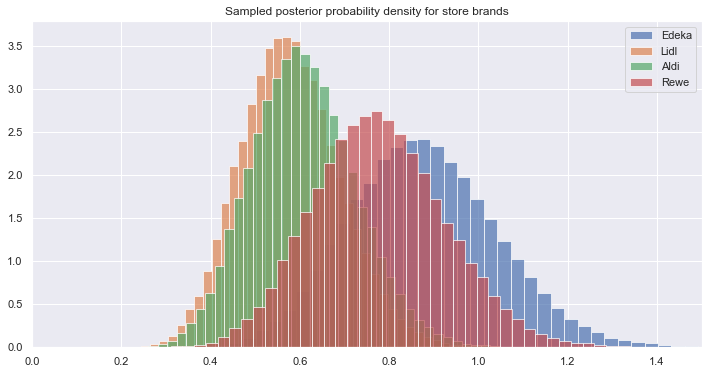

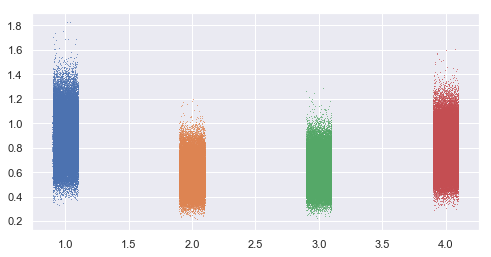

In [218]:
#Analysis of the base price for different supermarket brands

stan_summary_stores = fit.stansummary(pars=['mul_stores'], probs=[0.025, 0.5, 0.975])
print('\nResults:\n')
print(stan_summary_stores)

#dictionary for the labels
label_dic_store = {1:'Edeka', 2:'Lidl', 3:'Aldi', 4:'Rewe'}

#Plot the histogram
plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for store brands')
for i in range(4):
    plt.hist(posterior['mul_stores'][:,i],bins=50, density=True, alpha = 0.7, label = label_dic_store[i+1]) 
plt.xlim((0,1.5))    
plt.legend()
plt.show()

#Sample results for different stores
plt.figure(figsize=(8,4))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=80000), posterior['mul_stores'][:,i], ',', alpha=0.7)
plt.show()


Results:

Inference for Stan model: anon_model_986cbf8f5aef36cd96a0e82596de6f2b.
8 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=80000.

                      mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mul_neigborhoods[0]   0.94  9.1e-4   0.12   0.71   0.94    1.2  18373    1.0
mul_neigborhoods[1]    1.0  9.6e-4   0.13   0.75   0.99   1.27  18446    1.0
mul_neigborhoods[2]   1.04 10.0e-4   0.13   0.79   1.03   1.31  18051    1.0
mul_neigborhoods[3]   0.92  8.8e-4   0.12   0.69   0.91   1.16  18264    1.0
mul_neigborhoods[4]   0.97  9.4e-4   0.13   0.72   0.96   1.24  19872    1.0
mul_neigborhoods[5]   1.07  1.0e-3   0.14    0.8   1.06   1.36  18744    1.0
mul_neigborhoods[6]   1.12  1.1e-3   0.15   0.85   1.12   1.44  19149    1.0
mul_neigborhoods[7]   0.97  9.4e-4   0.14   0.71   0.96   1.25  20714    1.0
mul_neigborhoods[8]   1.02  1.0e-3   0.18    0.7   1.02    1.4  29777    1.0

Samples were drawn using 

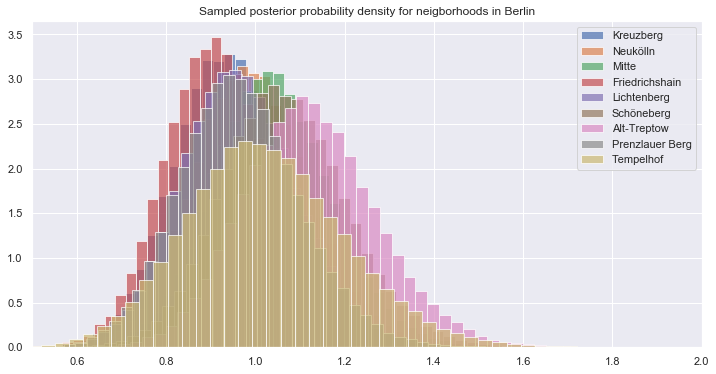

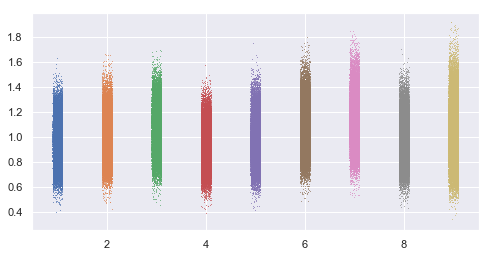

In [219]:


#Analysis of the base price for different locations
stan_summary_locations = fit.stansummary(pars=['mul_neigborhoods'], probs=[0.025, 0.5, 0.975])
print('\nResults:\n')
print(stan_summary_locations)


#dictionary for the labels
label_dic_neigborhoods = {1:"Kreuzberg",2:"Neukölln", 3:"Mitte", 4:"Friedrichshain",5: "Lichtenberg",
                         6:"Schöneberg", 7:"Alt-Treptow", 8:"Prenzlauer Berg",9: "Tempelhof"}

#Plot the histogram
plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for neigborhoods in Berlin')
for i in range(9):
    plt.hist(posterior['mul_neigborhoods'][:,i],bins=50, density=True, alpha = 0.7, label = label_dic_neigborhoods[i+1]) 
plt.xlim((0.5,2))    
plt.legend()
plt.show()

#Sample results for different neighborhoods
plt.figure(figsize=(8,4))
for i in range(9):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=80000), posterior['mul_neigborhoods'][:,i], ',', alpha=0.7)
plt.show()

##### Does price variation by geographical location correlates with variation in rental prices in Berlin/London, or not? 

To evaluate that I put the results for the price variation by geographical location correlate next to the mean rental prices. Then I calculated the Pearson correlation coefficient and graphed them in a scatter plot to see the overall distribution of the data.

I did not see a dominant pattern on the data. Pearson correlation coefficient shows a negative relationship between the rent and the mean multiplier for the neighborhood. It is counter-intuitive to me. However, it is 0.3, which means that it is a weak correlation. Also, since we concluded that the neighborhoods do not really affect the price, it is acceptable that there is not a correlation. Additionally, we had a small sample size for the rental prices, which might have also lowered the accuracy of our results. To evaluate the price difference in the retail stores in different neighborhoods, we should focus on local stores than chain stores because chain stores tend to have a global price within a country/city.


In [222]:
#Since there is limited metro stops available in certain neigborhoods, I chose 5 random stops to
#average out the number of available data for different points
#disclaimer: The neigborhoods of Tempelhof and Alttempelholf are close to each other thus there
#are overlapping stations
mitte = [1044,1048,1154,1090,1002]
schöneberg = [797,705,778,701,703,]
neukölln = [812,872,820,743,801]
kreuzberg = [865,895,941,908,1005]
friedrichschain = [976,842,942,892,809]
prenzaulerberg = [856,893,766,802,886]
tempelhof = [755, 743, 705, 820]
alttempelhof = [743,755,730,641]
lichtenberg = [739,736,752,809,734]
label_neigborhoods = ("Kreuzberg","Neukölln","Mitte", "Friedrichshain","Lichtenberg",
                         "Schöneberg", "Alt-Treptow","Prenzlauer Berg","Tempelhof")

#Creating a list with the rentalprices of different neigborhoods
rent = [np.mean(kreuzberg),np.mean(neukölln),np.mean(mitte),np.mean(friedrichschain),
        np.mean(lichtenberg),np.mean(schöneberg),np.mean(alttempelhof), np.mean(prenzaulerberg),
        np.mean(tempelhof)]

meanstan=np.mean(posterior['mul_neigborhoods'], axis=0)

#table with the mean rent prices and the mean multiplier values from the stan model
table = pd.DataFrame(list(zip(label_neigborhoods, rent, meanstan )), 
               columns =['Neigborhood', 'Average Rent', 'Mean Stan'])

print(table)



       Neigborhood  Average Rent  Mean Stan
0        Kreuzberg        922.80   0.941463
1         Neukölln        809.60   0.995309
2            Mitte       1067.60   1.038954
3   Friedrichshain        892.20   0.915474
4      Lichtenberg        754.00   0.966854
5       Schöneberg        736.80   1.065577
6      Alt-Treptow        717.25   1.123608
7  Prenzlauer Berg        840.60   0.965332
8        Tempelhof        755.75   1.024518


Pearson correlation coefficient -0.3569895676824669


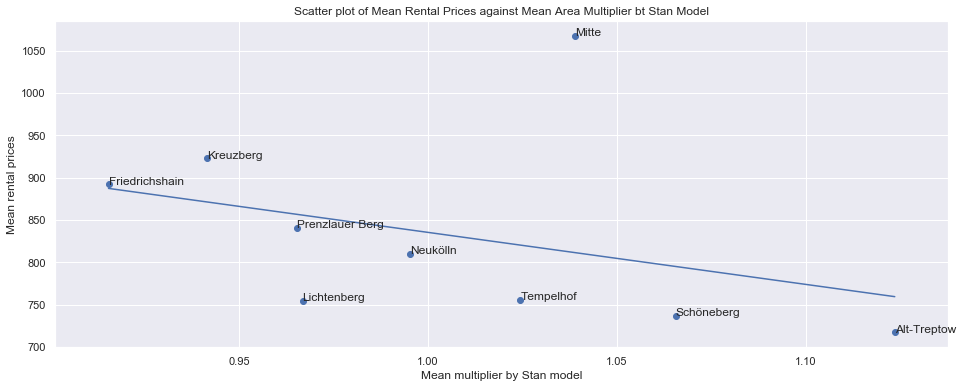

In [223]:
#Pearson correlation coefficient
print("Pearson correlation coefficient", table['Mean Stan'].corr(table['Average Rent']))

#plot the scatter plot 
plt.figure(figsize = (16,6))
plt.scatter(meanstan, rent)
plt.plot(np.unique(meanstan), np.poly1d(np.polyfit(meanstan, rent, 1))(np.unique(meanstan)))
plt.xlabel("Mean multiplier by Stan model")
plt.ylabel("Mean rental prices")
plt.title("Scatter plot of Mean Rental Prices against Mean Area Multiplier bt Stan Model")
for i, txt in enumerate(label_neigborhoods):
    plt.annotate(txt, (meanstan[i], rent[i]))

##### Metadata


###### ALDI Berlin Kreuzberg Straße 39
###### Schöneberg
###### 11/1/2019 11:35:00
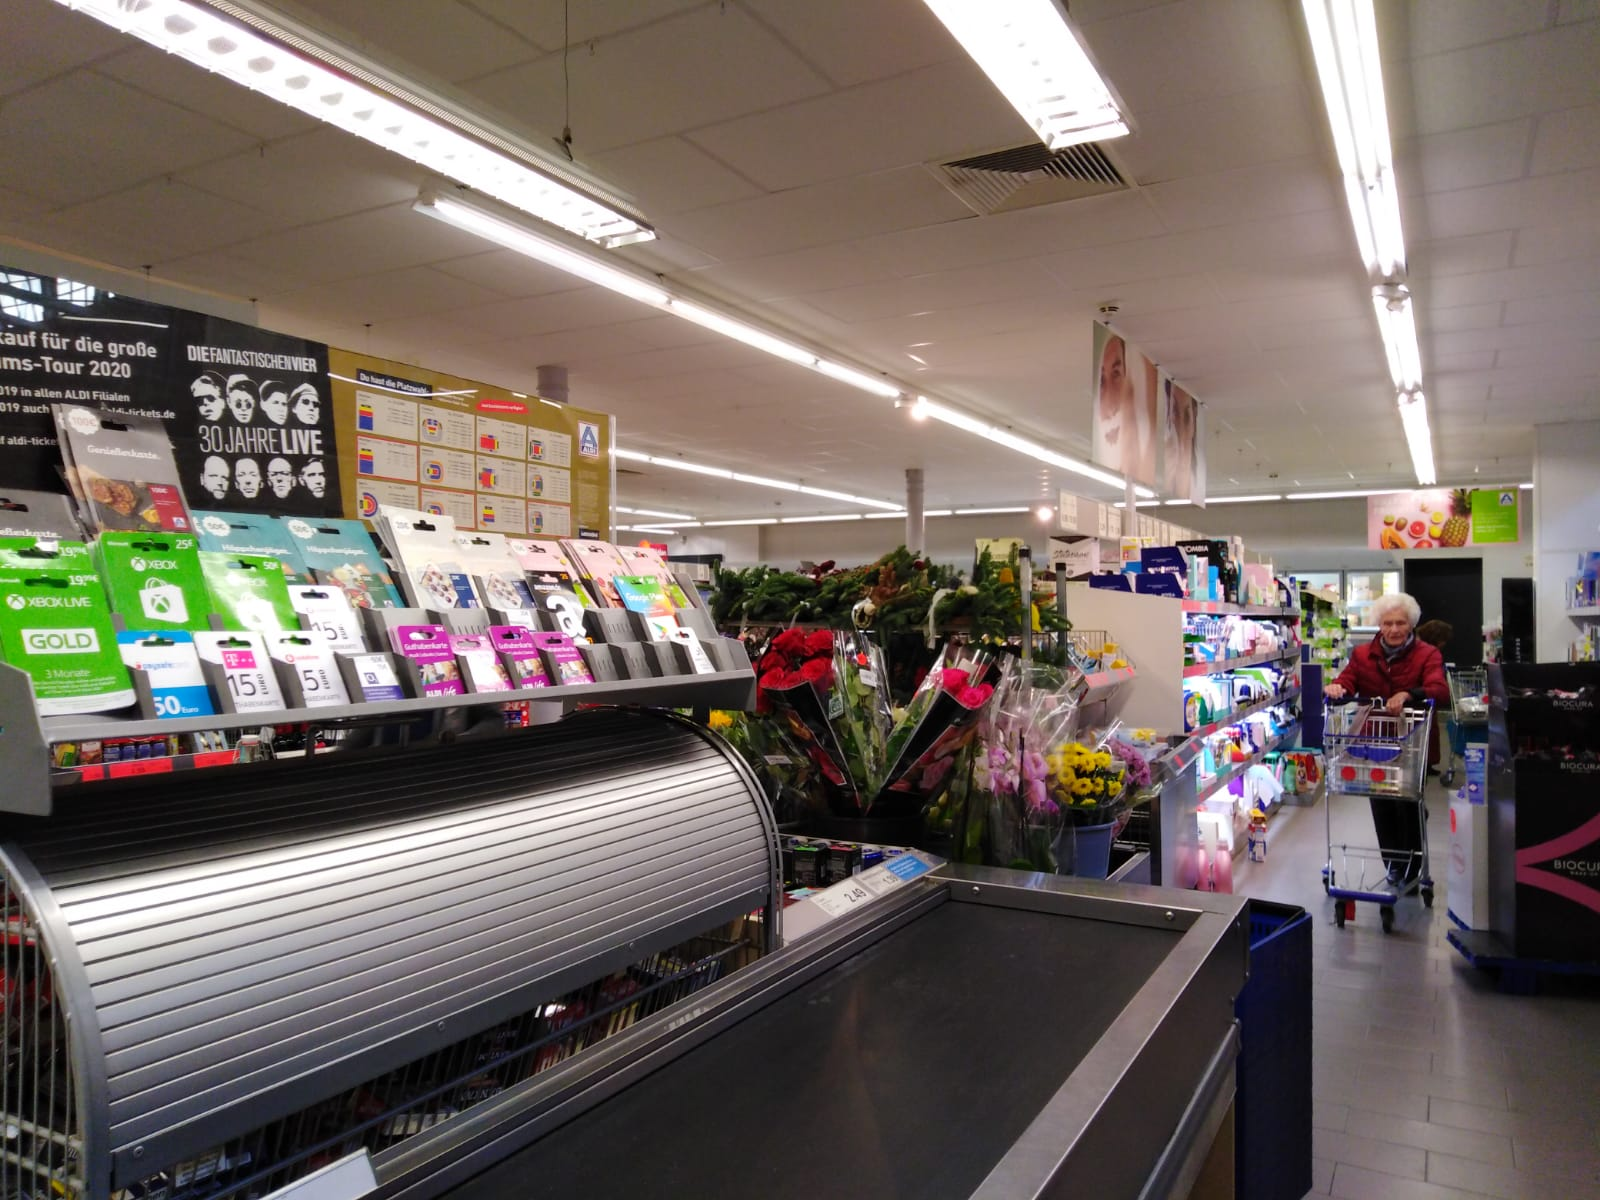

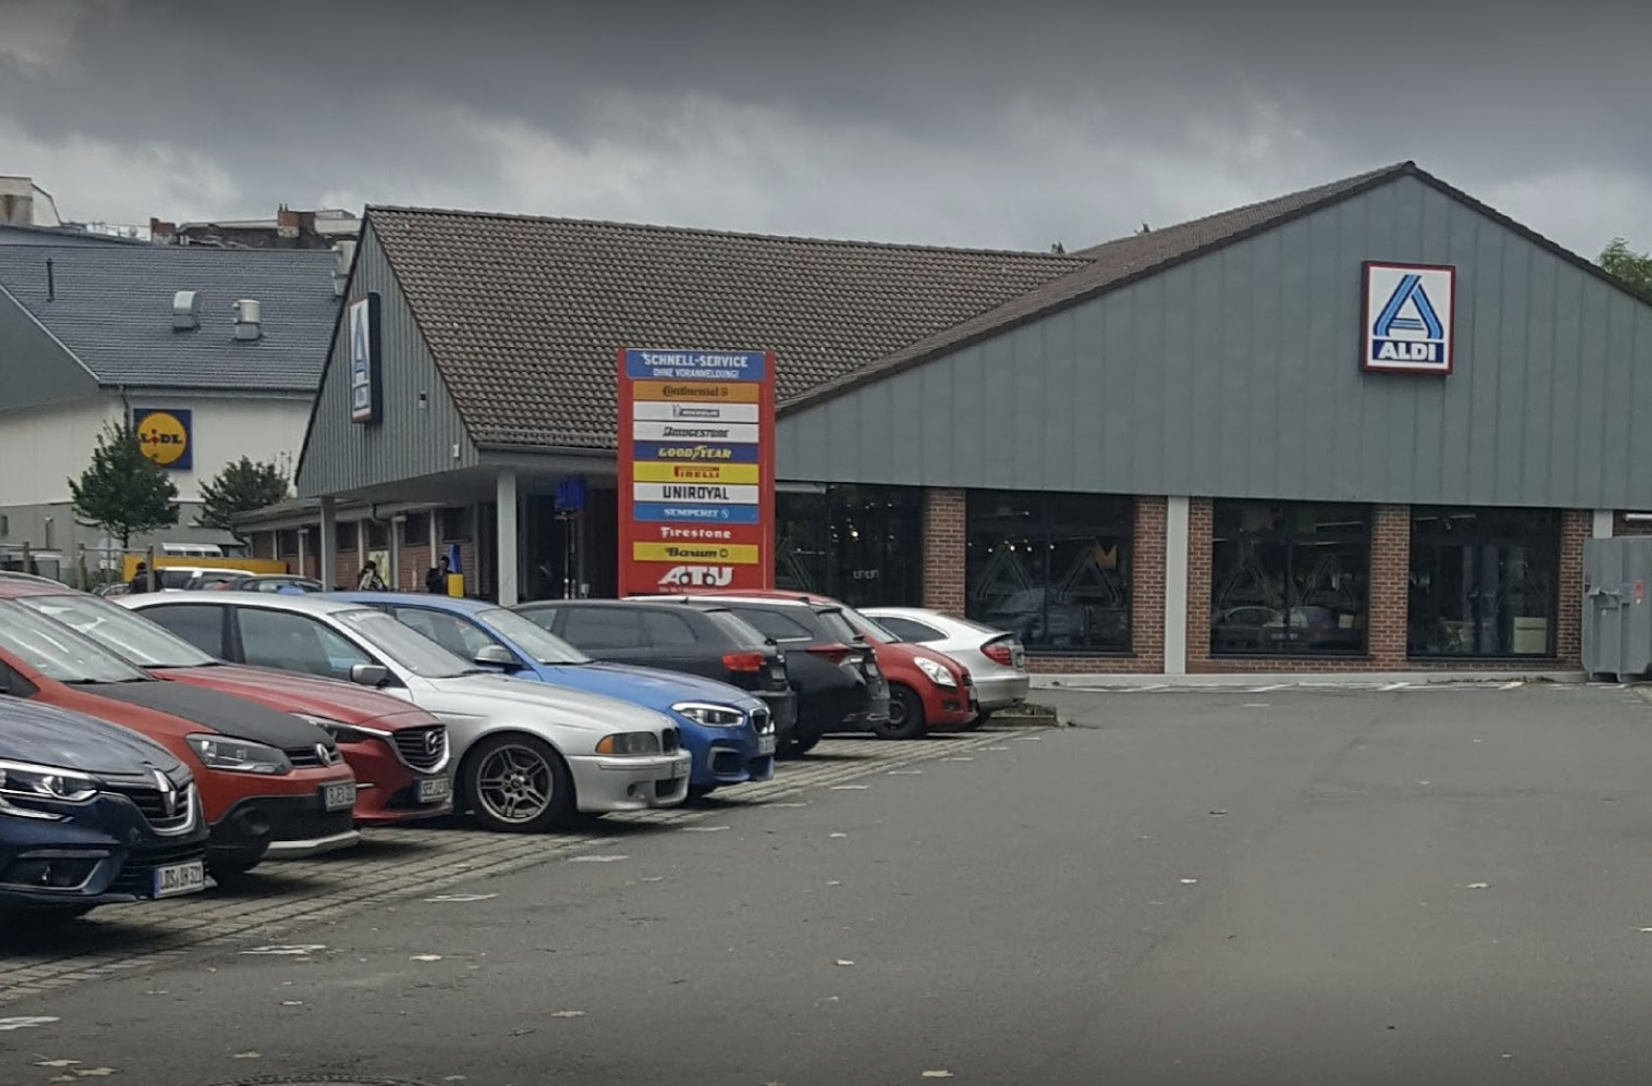
###### ALDI Eisenbahnstrasse 42
###### Kreuzberg
###### 11/1/2019 12:29:31

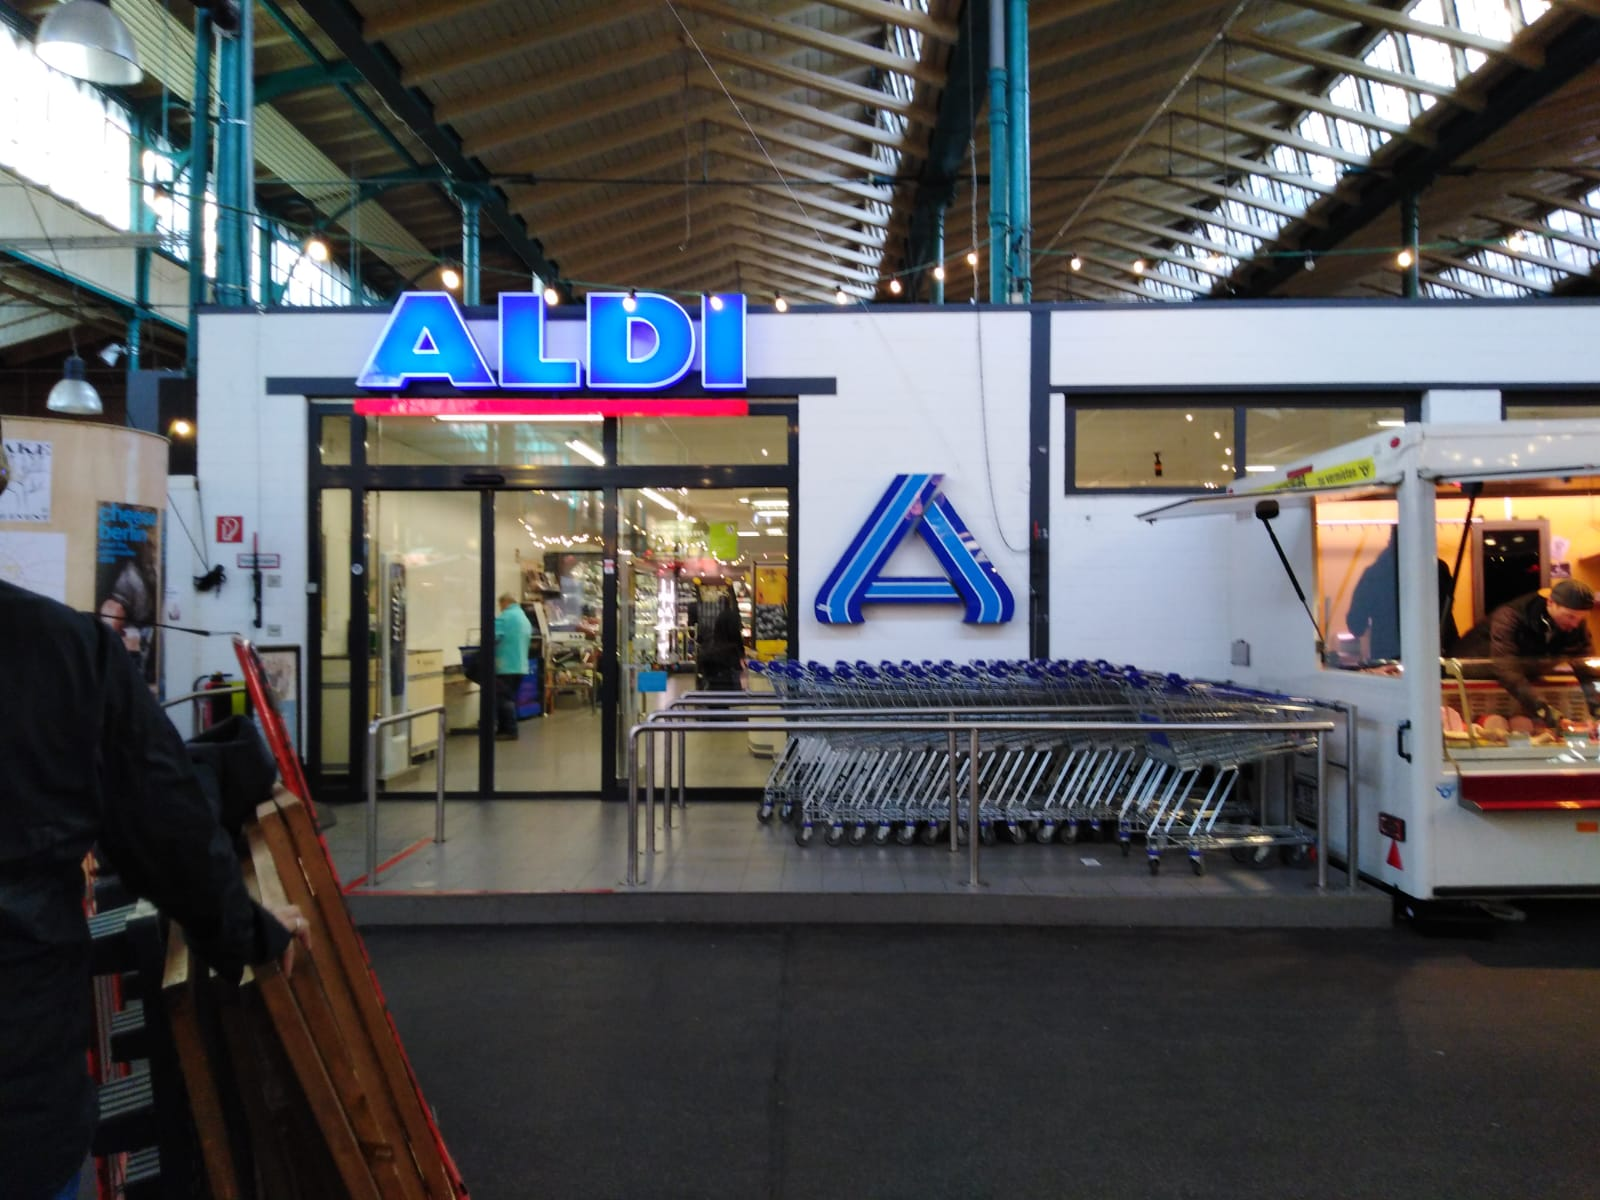